In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from exp.nb_05b import *

# Get data

In [2]:
x_train,y_train,x_valid,y_valid= get_data_normalized()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [3]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy


data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

bs,nh,c

(512, 50, 10)

# Convnet

In [4]:
# Create 'Lambda' module for pytorch: used for some basic function (e.g. reshape) and can be put in nn.Sequential
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [5]:
x_train.shape

torch.Size([60000, 784])

In [9]:
mnist_resize(x_train).shape

torch.Size([60000, 1, 28, 28])

In [11]:
flatten(mnist_resize(x_train)).shape

torch.Size([60000, 784])

In [6]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )


In [7]:
model = get_cnn_model(data)
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [8]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [9]:
loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [10]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [21]:
%time run.fit(1, learn)

train: [0.6877468098958334, tensor(0.7809)]
valid: [0.84636826171875, tensor(0.7229)]
CPU times: user 9.05 s, sys: 5.9 s, total: 15 s
Wall time: 3.77 s


# Using CUDA callback

A flexible way: Determine cuda device for each callback -> can use different cuda device for each callback (good for multi-GPU training?)

```python
device = torch.device('cuda',0)

class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

```

In [11]:
# Convenient way: 1 cuda device for all callbacks at once. Determine cuda device before hand

device = torch.device('cuda',0)
torch.cuda.set_device(device)

class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda() # send model to cuda at the beginning of training
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda() # send batch to cuda

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy),CudaCallback]

In [13]:
model = get_cnn_model(data)
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [28]:
%time run.fit(1, learn)

train: [0.5994508463541667, tensor(0.8114, device='cuda:0')]
valid: [1.01709287109375, tensor(0.6723, device='cuda:0')]
CPU times: user 744 ms, sys: 76.5 ms, total: 820 ms
Wall time: 822 ms


In [14]:
# combine conv2d and relu into one
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [15]:
# custom view for resizing 2d array into 3d imgs
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb) # with order 2, this will be applied AFTER cuda callback, at beginning of batch

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [16]:
mnist_view = view_tfm(1,28,28) 
mnist_view # this is the tfm func to be passed to BatchTransformXCallback

<function __main__.view_tfm.<locals>._inner(x)>

In [17]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f1714d23378>),
 __main__.CudaCallback]

In [18]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [19]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f1714d23378>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f16d3b3f950>)]

# Rewrite cnn layers and model

In [20]:
nfs = [8,16,32,32]

In [21]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3) for i in range(len(nfs)-1)
        # why for 1st layer, kernel size is 5 (bigger) instead of 2 or 3 (smaller).
        # because: e.g for kernel size 2, and 1 channel img, we have 2x2x1=4 inputs, and with 8 channels kernel, 
        # we will have 8 outputs when the 2x2x8 kernel is applied to a portion of the image
        # 4 inputs -> 8 outputs meaning we are trying to generate more information than it already has -> bad
        # Solution: We can increase kernel size from 2 to 5, so we now have 5x5x1=25 inputs and 8 outputs
        # which means now we can condense the information/pick out only interesting information to output
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [22]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [43]:
model = get_cnn_model(data, nfs)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [48]:
learn,run = get_runner(model, data, lr=0.2, cbs=cbfs)

In [49]:
run.fit(3, learn)

train: [0.16262819010416665, tensor(0.9502, device='cuda:0')]
valid: [0.49059609375, tensor(0.8462, device='cuda:0')]
train: [0.15084401041666667, tensor(0.9536, device='cuda:0')]
valid: [0.467985498046875, tensor(0.8614, device='cuda:0')]
train: [0.14091280924479166, tensor(0.9576, device='cuda:0')]
valid: [0.437481982421875, tensor(0.8744, device='cuda:0')]


# Keep track of mean and std of each activation

In [23]:
# break nn.Sequential into list of layers using nn.ModuleList
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.data.mean())
                self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [24]:
nfs

[8, 16, 32, 32]

In [25]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [73]:
model.layers

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [70]:
run.fit(2, learn)

train: [2.1695563802083333, tensor(0.1998, device='cuda:0')]
valid: [2.0464458984375, tensor(0.2880, device='cuda:0')]
train: [0.9011220052083333, tensor(0.7071, device='cuda:0')]
valid: [0.92034052734375, tensor(0.7024, device='cuda:0')]


Plot activation mean across layers

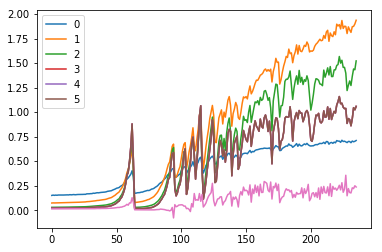

In [71]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

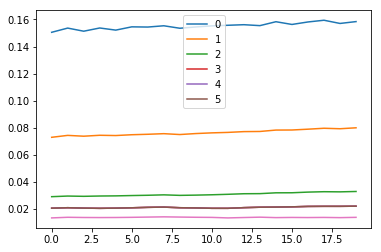

In [75]:
for l in model.act_means: plt.plot(l[:20])
plt.legend(range(6));

There are 'jump' patterns where activations' means jump to almost 1 then back

First 20 iterations (batches) seems to be okay though

Plot activation std across layers

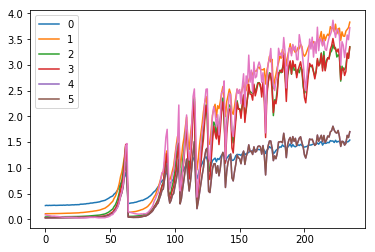

In [74]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

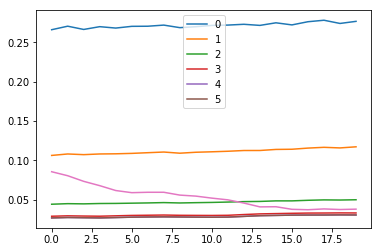

In [76]:
for l in model.act_stds: plt.plot(l[:20])
plt.legend(range(6));

Std got nowhere close to 1, and worst at last layers. At last layers std~=0, meaning activations are all close to 0, thus results in very small gradient when calculating grad_wrt_w for weight update -> vanishing gradient

# Using hooks

In [26]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f1714d23378>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f16d3b3f950>)]

In [27]:
data

In [28]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [29]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [30]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [31]:
# func to be passed to register_forward_hook: to decide what to do at one layer inp/outp
def append_stats(i, mod, inp, outp):
    if mod.training:
        act_means[i].append(outp.data.mean())
        act_stds [i].append(outp.data.std())

In [32]:
#register hook at each layer in model
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [89]:
run.fit(2, learn)

train: [2.0610565104166665, tensor(0.2539, device='cuda:0')]
valid: [1.93878984375, tensor(0.3511, device='cuda:0')]
train: [0.741404296875, tensor(0.7582, device='cuda:0')]
valid: [1.06941416015625, tensor(0.6414, device='cuda:0')]


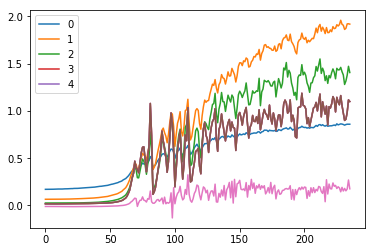

In [90]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

# Hook class: to remove hook when deleted

In [97]:
for i in model.children(): # the same with for i in model: print(i)
    print(i) 
    print('-')

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)
-
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
-
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
-
Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
-
AdaptiveAvgPool2d(output_size=1)
-
Lambda()
-
Linear(in_features=32, out_features=10, bias=True)
-


In [33]:
def children(m): return list(m.children()) # turn model layers into list so we can sublist them 

class Hook():# define a hook class for one hook at each layer
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):# pass in Hook obj in register_forward_hook function
    if not hasattr(hook,'stats'): hook.stats = ([],[])  # store mean and std as obj attributes
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

In [34]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [35]:
hooks = [Hook(l, append_stats) for l in children(model[:4])] # hook only the first 4, which are conv2d+relu layers

In [106]:
run.fit(2, learn)

train: [1.873344140625, tensor(0.3330, device='cuda:0')]
valid: [2.024685546875, tensor(0.3598, device='cuda:0')]
train: [0.641756640625, tensor(0.7968, device='cuda:0')]
valid: [0.89331494140625, tensor(0.7232, device='cuda:0')]


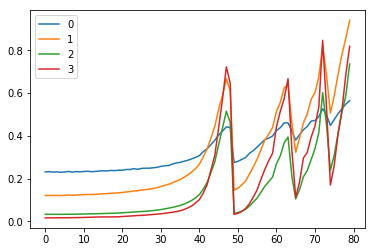

In [111]:
for h in hooks:
    plt.plot(h.stats[0][:80]) #plot mean, 1st 80 batches
    h.remove() # remove hook since we are done
plt.legend(range(4));

# Hooks: to contain a list of hook

Design to make this look like a numpy array: slice (arr[:5]), list of indices, mask of indices ...

In [36]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
#         print(idx)
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): 
        return iter(self.items) 
        # so if we have a ListContainer obj (e.g. lc), we can do ```for i in lc``` instead of ```for i in lc.items```
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [126]:
temp = ListContainer(range(10))
temp

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [119]:
temp[0],temp[1,2] # __getitem__ receive 1,2 as tuple, i.e. (1,2)

(0, [1, 2])

In [128]:
temp[1,2], temp[[1,2]]

([1, 2], [1, 2])

In [130]:
temp[[False]*6 + [True,False,True,False]]

[6, 8]

In [131]:
temp[0] = 1
temp

ListContainer (10 items)
[1, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [135]:
del temp[2]
temp

ListContainer (9 items)
[1, 1, 3, 4, 5, 6, 7, 8, 9]

In [136]:
for i in temp:
    print(i)

1
1
3
4
5
6
7
8
9


Now we can write our hooks using this structure

In [37]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms]) # use only 1 func for all hooks
    def __enter__(self, *args): return self # so we can use ```with Hooks(<init>) as hooks```
    def __exit__ (self, *args): self.remove() # so we can use ```with Hooks(<init>) as hooks```
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [38]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [39]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f16d3afad68>, <__main__.Hook object at 0x7f16d3afa470>, <__main__.Hook object at 0x7f16d3afa240>, <__main__.Hook object at 0x7f16d3b00b00>, <__main__.Hook object at 0x7f16d3b00908>, <__main__.Hook object at 0x7f16d3b00a90>, <__main__.Hook object at 0x7f16d3b00e80>]

In [40]:
hooks.remove()

# Fix mean and std problem with kaiming init

In [41]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [42]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

train: [1.6022071614583333, tensor(0.4492, device='cuda:0')]
valid: [1.23221318359375, tensor(0.5948, device='cuda:0')]
train: [0.5211374348958333, tensor(0.8365, device='cuda:0')]
valid: [1.1298091796875, tensor(0.6705, device='cuda:0')]


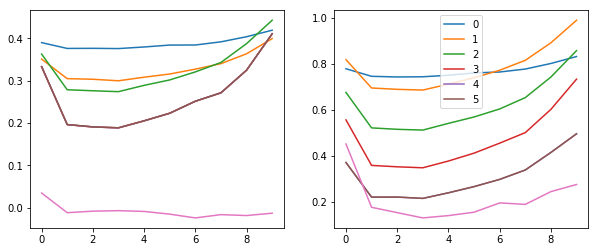

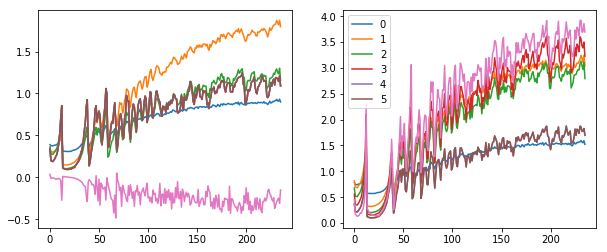

In [43]:
with Hooks(model, append_stats) as hooks: # Hooks will be auto removed with 'with'
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

Top 2 are mean and std for first 10 iterations: stds are now further from 0

# Store activation histogram

Since mean/std can't tell the individual activation. Histogram can at least check how many activations are small

In [44]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40,0,10)) # 40 bins, min 0 max 10
        #histc isn't implemented on the GPU

In [45]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.8, cbs=cbfs)

In [46]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [47]:
with Hooks(model, append_stats) as hooks: 
    run.fit(2, learn)

train: [1.8548619791666667, tensor(0.3573, device='cuda:0')]
valid: [1.52484140625, tensor(0.5004, device='cuda:0')]
train: [0.6120106119791666, tensor(0.8059, device='cuda:0')]
valid: [1.05000673828125, tensor(0.6815, device='cuda:0')]


In [48]:
len(hooks[0].stats[2]) 
# save a hist for each iteration. 236 iterations in total

236

In [49]:
hooks[0].stats[2][-1],hooks[0].stats[2][-1].shape
# 

(tensor([7.9590e+04, 9.2000e+03, 9.7600e+03, 2.2152e+04, 5.9580e+03, 7.9290e+03,
         2.4370e+03, 1.9190e+03, 1.6670e+03, 1.2320e+03, 9.4900e+02, 8.6900e+02,
         7.5100e+02, 6.7300e+02, 5.7100e+02, 5.8800e+02, 4.8600e+02, 4.4000e+02,
         3.7900e+02, 3.5200e+02, 2.9300e+02, 2.6700e+02, 2.6200e+02, 2.3800e+02,
         2.2000e+02, 2.3600e+02, 1.9100e+02, 1.6700e+02, 1.4300e+02, 1.3200e+02,
         1.0000e+02, 7.9000e+01, 8.3000e+01, 6.6000e+01, 4.6000e+01, 4.1000e+01,
         2.9000e+01, 1.8000e+01, 1.0000e+01, 3.0000e+00]), torch.Size([40]))

In [50]:
hooks[0].stats[2][-1].max(),hooks[0].stats[2][-1].min()

(tensor(79590.), tensor(3.))

In [51]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p() # Return matrix (# bins, # iterations)

<BarContainer object of 40 artists>

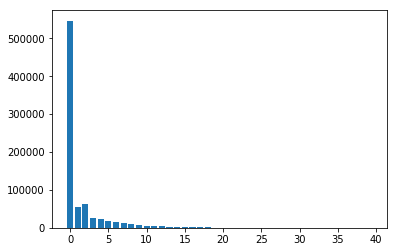

In [52]:
# without log
plt.bar(torch.arange(40),hooks[0].stats[2][3])

<BarContainer object of 40 artists>

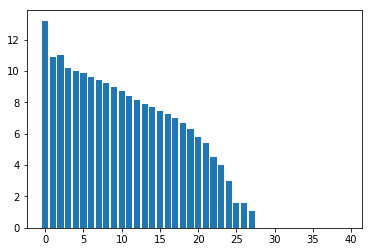

In [53]:
# with log: for visualization
plt.bar(torch.arange(40),get_hist(hooks[0])[:,3])

<BarContainer object of 40 artists>

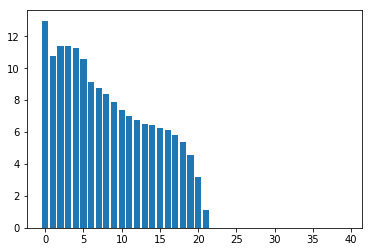

In [54]:
plt.bar(torch.arange(40),get_hist(hooks[0])[:,16])

<BarContainer object of 40 artists>

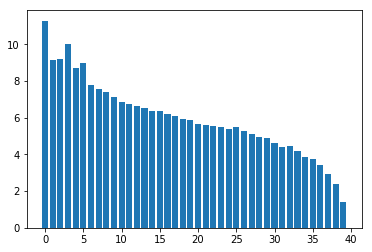

In [55]:
plt.bar(torch.arange(40),get_hist(hooks[0])[:,-1]) # few last iterations where there are more big activations

# Show 4 histograms of 4 conv layers (first 100 iterations)

The dark region is where values (count) are small. Light region (yellow) is where count are big

So for the first conv layer (upper left img) and first few iterations (<30) there are less big activations ((upper part) which results in darker region. This mean that there are more small activations (lower part). The yellow line at the bottom means there are lots of activations which are close to 0

For later iterations, it spreads equally

Note that we only record activations between 0 and 10. Low activations are close to 0

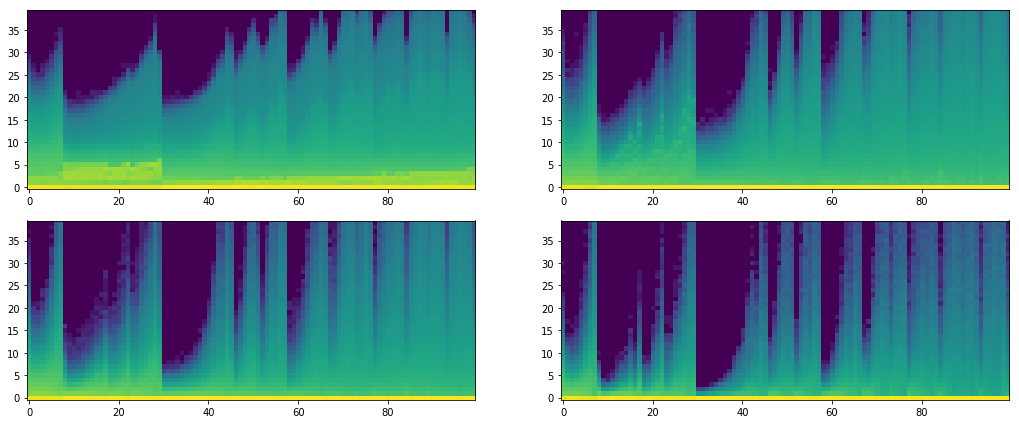

In [56]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h)[:,:100], origin='lower')
    ax.axis('on')
plt.tight_layout()

# Show 4 histograms of 4 conv layers (all iterations)

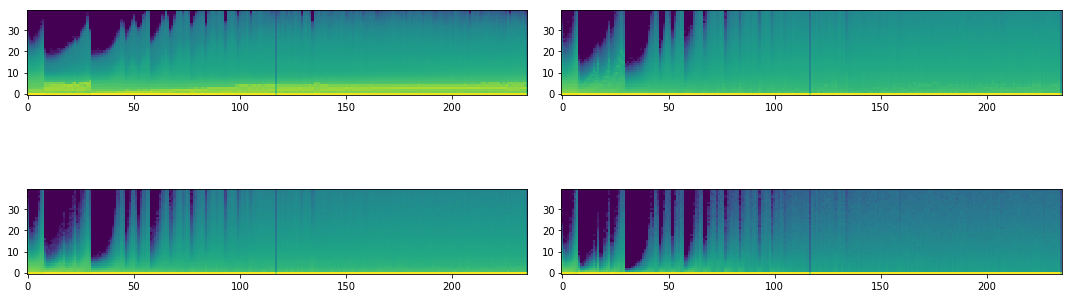

In [57]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('on')
plt.tight_layout()

## Count how much of activations are in the first 2 bins (0 and close to 0)

In [58]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

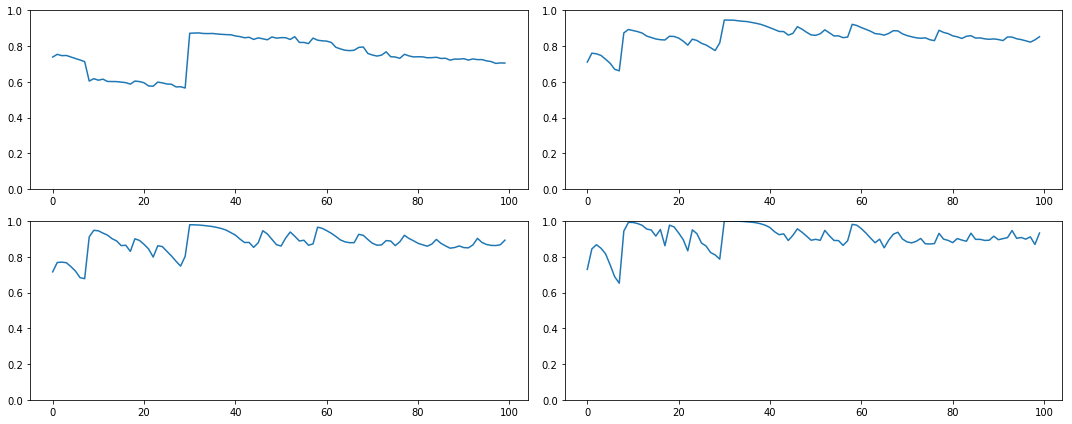

In [59]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h)[:100])
    ax.set_ylim(0,1)
plt.tight_layout()

In [60]:
model[3]

Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

At layer 3 (last conv layer, lower right img), almost 90% of activations are 0 -> lots of wasted activations

We will try to fix this problem with a better RELU activation

# Generalized RELU

In [63]:
??get_cnn_layers

In [64]:
??conv2d

In [65]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs)) # replace RELU with generalRELU

In [66]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None): # we can now add leaky portion/ subtraction/ max RELU value to clip
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [68]:
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1) # a: negative slope of rectifier used after this layer?
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [69]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40,-7,7))

In [72]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.8, cbs=cbfs)

In [74]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

train: [0.8181676432291667, tensor(0.7387, device='cuda:0')]
valid: [0.93376748046875, tensor(0.7028, device='cuda:0')]
train: [0.3047334635416667, tensor(0.9066, device='cuda:0')]
valid: [0.603224072265625, tensor(0.8135, device='cuda:0')]


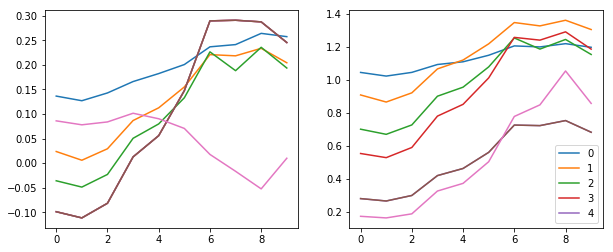

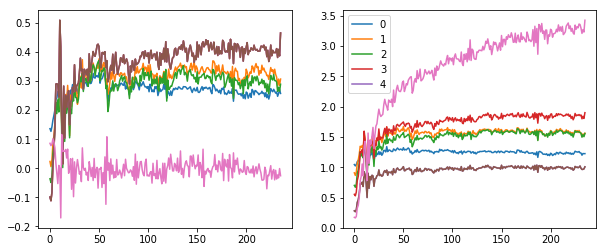

In [73]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

Comparing that to mean and stds from kaiming init:
- Stds moves away from 0 faster at first few iterations, and eventually become stable around 1 and 1.5 (unlike kaiming's where some layers' stds move up to 3
- Means are close to 0 and stable (in kaiming's means can reach up to -0.5 or 1

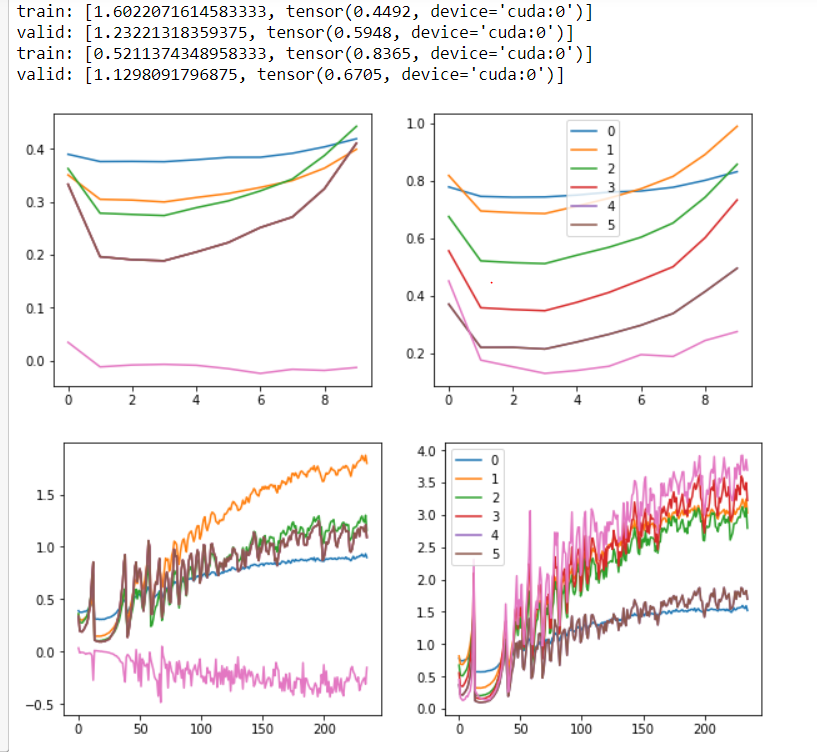

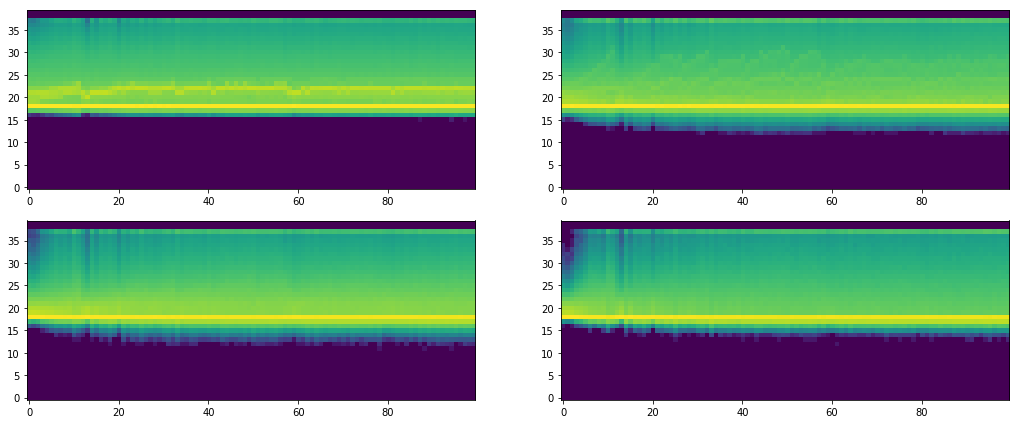

In [77]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h)[:,:100], origin='lower')
    ax.axis('on')
plt.tight_layout()

Dark region is less now, meaning there are less activations close to 0, even though the yellow line are still distinguisable.

<BarContainer object of 40 artists>

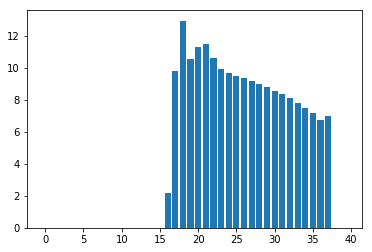

In [78]:
plt.bar(torch.arange(40),get_hist(hooks[0])[:,3])

<BarContainer object of 40 artists>

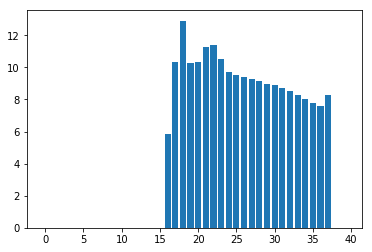

In [79]:
plt.bar(torch.arange(40),get_hist(hooks[0])[:,10])

In [80]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0) # bin 19,20 and 21 are the middle, where ~0 values stay

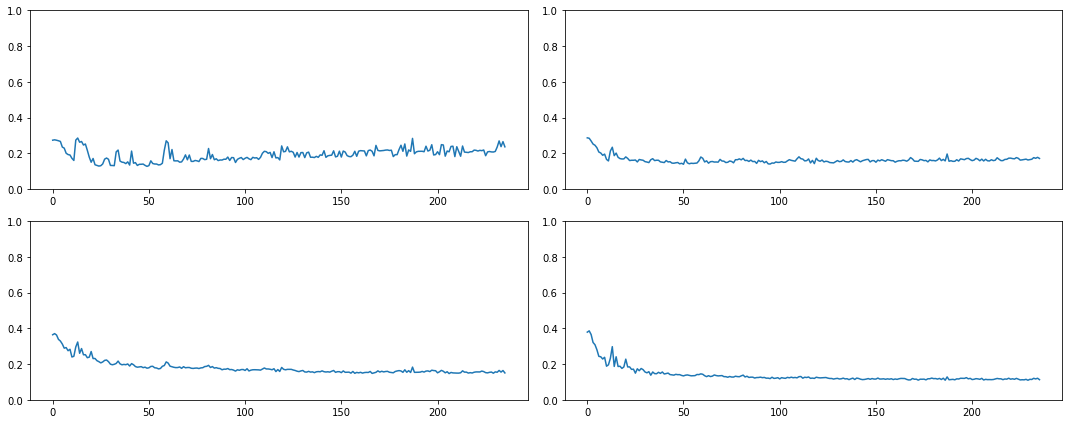

In [81]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

All layers now has about 20% ~0 activations on average -> huge improvement

# Running full model with new settings

In [88]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [89]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.1, 1.), sched_cos(1., 0.06)])

In [90]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [91]:
run.fit(8, learn)

train: [1.45277890625, tensor(0.5172, device='cuda:0')]
valid: [1.30371025390625, tensor(0.5762, device='cuda:0')]
train: [0.6904897135416667, tensor(0.7801, device='cuda:0')]
valid: [1.3610826171875, tensor(0.5597, device='cuda:0')]
train: [0.48477535807291666, tensor(0.8494, device='cuda:0')]
valid: [0.8646841796875, tensor(0.7302, device='cuda:0')]
train: [0.2981134440104167, tensor(0.9065, device='cuda:0')]
valid: [0.834971484375, tensor(0.7528, device='cuda:0')]
train: [0.29711240234375, tensor(0.9089, device='cuda:0')]
valid: [0.455334765625, tensor(0.8698, device='cuda:0')]
train: [0.14936131184895834, tensor(0.9545, device='cuda:0')]
valid: [0.394821240234375, tensor(0.8741, device='cuda:0')]
train: [0.11623482259114583, tensor(0.9650, device='cuda:0')]
valid: [0.352640625, tensor(0.8967, device='cuda:0')]
train: [0.09922086588541666, tensor(0.9707, device='cuda:0')]
valid: [0.3445960205078125, tensor(0.8982, device='cuda:0')]


## Try kaiming uniform init instead of kaiming normal

Normal distribution can put lots of weight near 0

In [92]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [93]:
run.fit(8, learn)

train: [1.55311640625, tensor(0.4840, device='cuda:0')]
valid: [1.4608732421875, tensor(0.5115, device='cuda:0')]
train: [0.7416473307291667, tensor(0.7631, device='cuda:0')]
valid: [1.159045703125, tensor(0.6437, device='cuda:0')]
train: [0.48162373046875, tensor(0.8500, device='cuda:0')]
valid: [0.925874609375, tensor(0.7366, device='cuda:0')]
train: [0.31029270833333333, tensor(0.9043, device='cuda:0')]
valid: [0.71277802734375, tensor(0.7968, device='cuda:0')]
train: [0.18547679036458334, tensor(0.9440, device='cuda:0')]
valid: [0.447143212890625, tensor(0.8727, device='cuda:0')]
train: [0.13640869140625, tensor(0.9585, device='cuda:0')]
valid: [0.396031787109375, tensor(0.8859, device='cuda:0')]
train: [0.10268295084635416, tensor(0.9691, device='cuda:0')]
valid: [0.3592739501953125, tensor(0.8999, device='cuda:0')]
train: [0.08625625, tensor(0.9746, device='cuda:0')]
valid: [0.3448911865234375, tensor(0.9030, device='cuda:0')]
